In [1]:
# Clear Kaggle Working Directory
!rm -rf /kaggle/working/*

In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import pandas as pd
from skimage import color
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
import warnings

print("CUDA Available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings('ignore', message='.*CIE-LAB.*negative Z values.*')

CUDA Available: True


In [3]:
# Model
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dim=256):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, feature_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x1 = self.conv1(x)  # [B, 64, H, W]
        x2 = self.conv2(x1) # [B, 128, H/2, W/2]
        x3 = self.conv3(x2) # [B, 256, H/4, W/4]
        x4 = self.conv4(x3) # [B, 256, H/4, W/4]
        return x4, (x1, x2, x3)


class TransformerEncoder(nn.Module):
    def __init__(self, feature_dim=256, num_heads=8, num_layers=4, patch_size=4, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        self.patch_size = patch_size
        
        patch_dim = patch_size * patch_size * feature_dim
        self.patch_projection = nn.Linear(patch_dim, feature_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 256, feature_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim,
            nhead=num_heads,
            dim_feedforward=feature_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        B, C, H, W = x.shape

        # Split feature map into patches
        x = x.unfold(2, self.patch_size, self.patch_size)\
             .unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, C, -1, self.patch_size * self.patch_size)
        x = x.permute(0, 2, 1, 3).flatten(2)

        # Project patches
        x = self.patch_projection(x)
        
        # Add positional embedding
        num_patches = x.size(1)
        if num_patches <= self.pos_embed.size(1):
            pos_emb = self.pos_embed[:, :num_patches, :]
        else:
            pos_emb = F.interpolate(
                self.pos_embed.permute(0, 2, 1),
                size=num_patches,
                mode='linear',
                align_corners=False
            ).permute(0, 2, 1)
        
        x = x + pos_emb
        x = self.transformer(x)
        return x, (H, W)


class ColourDecoder(nn.Module):
    def __init__(self, feature_dim=256):
        super().__init__()
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256 + 256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        self.up3 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 2, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x, orig_H, orig_W, skip_features=None):
        B, N, C = x.shape
        side = int(N ** 0.5)
        
        x = x.permute(0, 2, 1).view(B, C, side, side)
        x = self.up1(x)
        
        if skip_features is not None:
            skip3 = skip_features[2]
            if skip3.shape[2:] != x.shape[2:]:
                skip3 = F.interpolate(skip3, size=x.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip3], dim=1)
        
        x = self.up2(x)
        
        if skip_features is not None:
            skip2 = skip_features[1]
            if skip2.shape[2:] != x.shape[2:]:
                skip2 = F.interpolate(skip2, size=x.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip2], dim=1)
        
        x = self.up3(x)
        
        if skip_features is not None:
            skip1 = skip_features[0]
            if skip1.shape[2:] != x.shape[2:]:
                skip1 = F.interpolate(skip1, size=x.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip1], dim=1)
        
        x = self.final(x)
        
        if x.shape[2] != orig_H or x.shape[3] != orig_W:
            x = F.interpolate(x, size=(orig_H, orig_W), mode="bilinear", align_corners=False)
        
        return x


class CNNTransformerColourizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.transformer = TransformerEncoder(dropout=0.1)
        self.decoder = ColourDecoder()

    def forward(self, x):
        orig_H, orig_W = x.shape[2], x.shape[3]
        feat, skip_features = self.encoder(x)
        trans, (enc_H, enc_W) = self.transformer(feat)
        ab = self.decoder(trans, orig_H, orig_W, skip_features)
        return ab

In [4]:
# Upload model to kaggle and run it
MODEL_PATH = "/kaggle/input/final-v1/pytorch/default/1/checkpoint_epoch_055.pth"

checkpoint = torch.load(MODEL_PATH, map_location=device)

model = CNNTransformerColourizer().to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model loaded successfully")

Model loaded successfully


In [5]:
# Dataset
DATA_ROOT = "/kaggle/input/150k-data/processed"

GRAY_VAL  = os.path.join(DATA_ROOT, "grayscale/val")
COLOR_VAL = os.path.join(DATA_ROOT, "color/val")

print("Grayscale val path:", GRAY_VAL)
print("Color val path:", COLOR_VAL)

Grayscale val path: /kaggle/input/150k-data/processed/grayscale/val
Color val path: /kaggle/input/150k-data/processed/color/val


In [6]:
def collect_pairs(gray_root, color_root):
    pairs = []

    for cls in sorted(os.listdir(gray_root)):
        gray_cls = os.path.join(gray_root, cls)
        color_cls = os.path.join(color_root, cls)

        if not os.path.isdir(gray_cls):
            continue

        for fname in sorted(os.listdir(gray_cls)):
            if not fname.endswith('.jpg'):  # Skip non-image files
                continue
                
            g = os.path.join(gray_cls, fname)
            
            # Replace .jpg with .npy for color file
            color_fname = fname.replace('.jpg', '.npy')
            c = os.path.join(color_cls, color_fname)

            if os.path.exists(c):
                pairs.append((g, c))

    return pairs

In [7]:
val_pairs = collect_pairs(GRAY_VAL, COLOR_VAL)

print("Total validation images:", len(val_pairs))

# Skip the first 4k since it was used in our training loop
SKIP = 4000
val_pairs = val_pairs[SKIP:]

print("Validation images after skip:", len(val_pairs))

Total validation images: 36500
Validation images after skip: 32500


In [8]:
def load_L(path):
    img = Image.open(path).convert("RGB")
    img_np = np.array(img) / 255.0
    lab = color.rgb2lab(img_np)
    L = lab[:, :, 0] / 100.0
    return torch.from_numpy(L).unsqueeze(0).unsqueeze(0).float(), img_np


def lab_to_rgb(L, ab, saturation_boost=1.0, suppress_warnings=True):
    L = L * 100.0
    
    # Apply saturation boost to AB channels
    if saturation_boost != 1.0:
        ab = ab * saturation_boost
        ab = np.clip(ab, -128, 128)
    
    # Transpose ab from (2, H, W) to (H, W, 2) if needed
    if ab.ndim == 3 and ab.shape[0] == 2:
        ab = ab.transpose(1, 2, 0)

    lab = np.zeros((L.shape[0], L.shape[1], 3))
    lab[:, :, 0] = L
    lab[:, :, 1:] = ab

    # You do not want to see a wall of RED
    if suppress_warnings:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='.*CIE-LAB.*negative Z values.*')
            rgb = color.lab2rgb(lab)
    else:
        rgb = color.lab2rgb(lab)
    
    # Clip RGB to valid range [0, 1] before converting to uint8
    rgb = np.clip(rgb, 0, 1)
    return (rgb * 255).astype(np.uint8)


def load_color_npy(path):
    """Load AB channels from .npy file normalized to [-1, 1]"""
    gt_ab = np.load(path)
    # Denormalize from [-1, 1] to [-128, 128]
    gt_ab = gt_ab * 128.0
    return gt_ab

In [9]:
def psnr(gt, pred):
    return peak_signal_noise_ratio(gt, pred, data_range=255)

def ssim(gt, pred):
    return structural_similarity(gt, pred, channel_axis=2, data_range=255)

def mae_ab(gt, pred):
    gt_lab = color.rgb2lab(gt / 255.0)
    pr_lab = color.rgb2lab(pred / 255.0)
    return np.mean(np.abs(gt_lab[:, :, 1:] - pr_lab[:, :, 1:]))

In [10]:
class ColorizationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        g_path, c_path = self.pairs[idx]
        
        # Load grayscale (L channel)
        img = Image.open(g_path).convert("RGB")
        img_np = np.array(img) / 255.0
        lab = color.rgb2lab(img_np)
        L = lab[:, :, 0] / 100.0
        L_tensor = torch.from_numpy(L).unsqueeze(0).float()

        # Shape should be (H, W, 2)
        gt_ab = np.load(c_path)  
        gt_ab = gt_ab * 128.0
        
        return L_tensor, torch.from_numpy(L).float(), torch.from_numpy(gt_ab).float()


# Create DataLoader
dataset = ColorizationDataset(val_pairs)
dataloader = DataLoader(
    dataset, 
    batch_size=32,
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)

print(f"Created DataLoader with {len(dataset)} samples")
print(f"Number of batches: {len(dataloader)}")

Created DataLoader with 32500 samples
Number of batches: 1016


In [11]:
psnr_scores, ssim_scores, mae_scores = [], [], []
top5_results = []          # Store top 5 SSIM results

SATURATION_BOOST = 2.5
batch_idx = 0              # Track which batch we're in

for L_batch, L_numpy_batch, gt_ab_batch in tqdm(dataloader, desc="Evaluating..."):
    L_batch = L_batch.to(device, non_blocking=True)
    
    with torch.no_grad():
        ab_batch = model(L_batch)  # [B, 2, H, W]
        ab_batch = ab_batch * 128.0
    
    # Process each image in batch
    for i in range(L_batch.size(0)):
        # Calculate global index
        global_idx = batch_idx * dataloader.batch_size + i
        
        L_numpy = L_numpy_batch[i].cpu().numpy()
        ab_pred = ab_batch[i].cpu().numpy().transpose(1, 2, 0)  # [H, W, 2]
        gt_ab = gt_ab_batch[i].cpu().numpy()  # [H, W, 2]

        # Grayscale image for visualization
        gray_rgb = (np.stack([L_numpy] * 3, axis=-1) * 255).astype(np.uint8)
        
        # Convert prediction to RGB
        colored_rgb = lab_to_rgb(L_numpy, ab_pred, saturation_boost=1.0)
        
        # Convert prediction to RGB with  boost
        boosted_rgb = lab_to_rgb(L_numpy, ab_pred, saturation_boost=SATURATION_BOOST)
        
        # Convert ground truth to RGB 
        gt_rgb = lab_to_rgb(L_numpy, gt_ab, saturation_boost=1.0)

        # Evaluate Metrics using prediction vs ground truth
        psnr_val = psnr(gt_rgb, colored_rgb)
        ssim_val = ssim(gt_rgb, colored_rgb)
        mae_val = mae_ab(gt_rgb, colored_rgb)
        
        psnr_scores.append(psnr_val)
        ssim_scores.append(ssim_val)
        mae_scores.append(mae_val)
        
        # Store result for top 5 tracking
        result_entry = {
            'index': global_idx,
            'file_path': val_pairs[global_idx][0],  # grayscale path
            'ssim': ssim_val,
            'psnr': psnr_val,
            'mae': mae_val,
            'gray': gray_rgb,
            'colored': colored_rgb,    
            'boosted': boosted_rgb, 
            'pred': colored_rgb, 
            'gt': gt_rgb
        }
        
        # Maintain top 5 by SSIM
        top5_results.append(result_entry)
        top5_results.sort(key=lambda x: x['ssim'], reverse=True)
        top5_results = top5_results[:5]  
    
    batch_idx += 1

print("\n Doneeeee!")

Evaluating...: 100%|██████████| 1016/1016 [36:20<00:00,  2.15s/it]


 Doneeeee!


In [12]:
print("\n Evaluation completed:")
print(f"   Average PSNR: {np.mean(psnr_scores):.2f} dB")
print(f"   Average SSIM: {np.mean(ssim_scores):.4f}")
print(f"   Average MAE (AB): {np.mean(mae_scores):.2f}")


 Evaluation completed:
   Average PSNR: 22.37 dB
   Average SSIM: 0.9052
   Average MAE (AB): 10.24


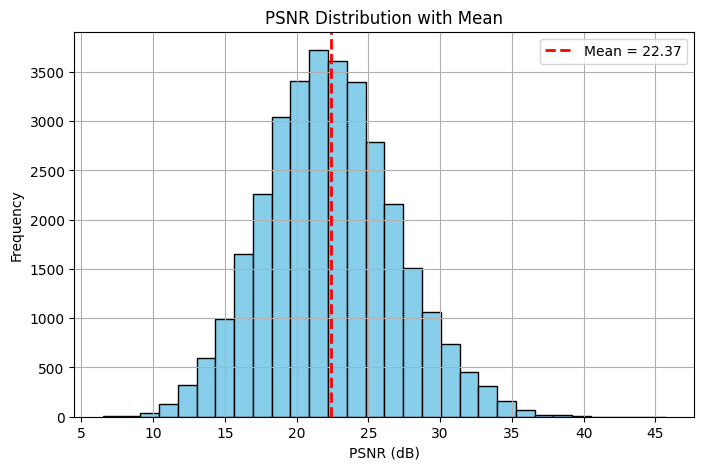

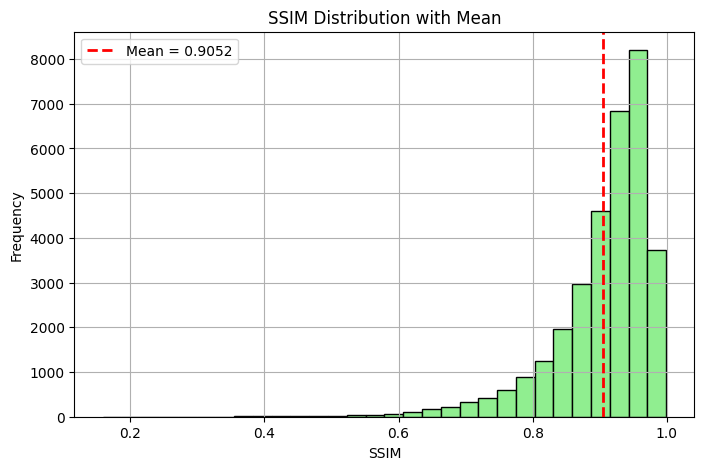

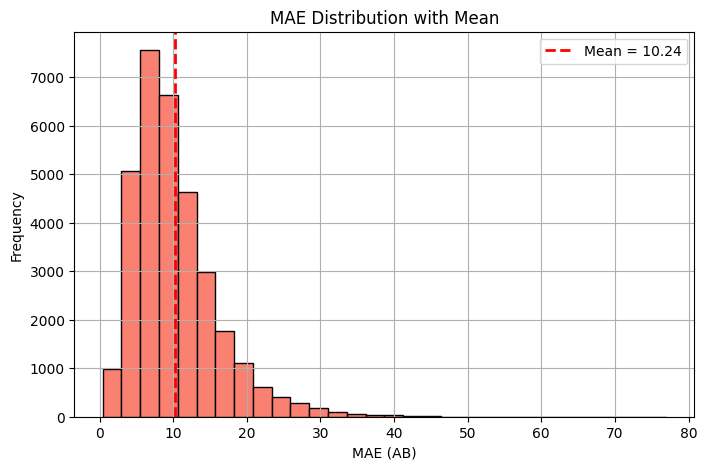

In [18]:
# Example for PSNR
mean_psnr = np.mean(psnr_scores)

plt.figure(figsize=(8,5))
plt.hist(psnr_scores, bins=30, color='skyblue', edgecolor='black')  # frequency histogram
plt.axvline(mean_psnr, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_psnr:.2f}') 
plt.xlabel("PSNR (dB)")
plt.ylabel("Frequency")
plt.title("PSNR Distribution with Mean")
plt.legend()
plt.grid(True)
plt.show()

# Similarly for SSIM
mean_ssim = np.mean(ssim_scores)
plt.figure(figsize=(8,5))
plt.hist(ssim_scores, bins=30, color='lightgreen', edgecolor='black')
plt.axvline(mean_ssim, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_ssim:.4f}')
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.title("SSIM Distribution with Mean")
plt.legend()
plt.grid(True)
plt.show()

# And for MAE
mean_mae = np.mean(mae_scores)
plt.figure(figsize=(8,5))
plt.hist(mae_scores, bins=30, color='salmon', edgecolor='black')
plt.axvline(mean_mae, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_mae:.2f}')
plt.xlabel("MAE (AB)")
plt.ylabel("Frequency")
plt.title("MAE Distribution with Mean")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
stats = {
    "Metric": ["PSNR", "SSIM", "MAE (AB)"],
    "Mean": [np.mean(psnr_scores), np.mean(ssim_scores), np.mean(mae_scores)],
    "Std Dev": [np.std(psnr_scores), np.std(ssim_scores), np.std(mae_scores)],
    "Min": [np.min(psnr_scores), np.min(ssim_scores), np.min(mae_scores)],
    "Max": [np.max(psnr_scores), np.max(ssim_scores), np.max(mae_scores)],
}

# Convert to DataFrame for a nice table display
stats_df = pd.DataFrame(stats)

# Optional: format numbers for readability
stats_df["Mean"] = stats_df["Mean"].map(lambda x: f"{x:.4f}")
stats_df["Std Dev"] = stats_df["Std Dev"].map(lambda x: f"{x:.4f}")
stats_df["Min"] = stats_df["Min"].map(lambda x: f"{x:.4f}")
stats_df["Max"] = stats_df["Max"].map(lambda x: f"{x:.4f}")

# Display the table
print(stats_df)

     Metric     Mean Std Dev     Min      Max
0      PSNR  22.3749  4.5767  6.4879  45.7470
1      SSIM   0.9052  0.0754  0.1587   0.9989
2  MAE (AB)  10.2436  5.7963  0.4146  76.9725
